In [30]:
## data.py
import pandas as pd
import numpy as np
import torch

## Deep Ritz Method for Solving PDEs  
The Deep Ritz Method is a neural network-based approach for solving partial differential equations (PDEs) by reformulating the problem as a variational problem. This method leverages the expressive power of deep neural networks to approximate the solution of PDEs.

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [32]:
def sample_interior(n_samples):
    """Sample points in the interior of the domain [0, 1] x [0, 1]."""
    x = np.random.uniform(0, 1, (n_samples, 1))
    y = np.random.uniform(0, 1, (n_samples, 1))
    return torch.tensor(np.hstack((x, y)), dtype=torch.float32).to(device)

def sample_boundary(n_samples, require_normals=False):
    """
    Sample points and normal vectorson the boundary of the domain [0, 1] x [0, 1].
    Returns:
        points: Tensor of shape (n_samples, 2) containing boundary points.
        normals: Tensor of shape (n_samples, 2) containing normal vectors at the boundary points.
    """
    n_samples_per_side = n_samples // 4
    # Four sides of the square
    left = np.stack((np.zeros((n_samples_per_side)), np.random.uniform(0, 1, (n_samples_per_side))), axis=1)
    right = np.stack((np.ones((n_samples_per_side)), np.random.uniform(0, 1, (n_samples_per_side))), axis=1)
    bottom = np.stack((np.random.uniform(0, 1, (n_samples_per_side)), np.zeros((n_samples_per_side))), axis=1)
    top = np.stack((np.random.uniform(0, 1, (n_samples_per_side)), np.ones((n_samples_per_side))), axis=1)
    
    #stack all boundary points
    points = np.vstack((left, right, bottom, top))
    normals = None
    
    if require_normals:
        #normal vectors 
        normals = np.vstack([
            np.tile([-1, 0], (n_samples_per_side, 1)),  # left
            np.tile([1, 0], (n_samples_per_side, 1)),
            np.tile([0, -1], (n_samples_per_side, 1)),  # bottom
            np.tile([0, 1], (n_samples_per_side, 1))   # top
        ])
    
    return (
        torch.tensor(points, dtype=torch.float32).to(device),
        torch.tensor(normals, dtype=torch.float32).to(device) if require_normals else None
    )
       

def generate_samples(n_interior, n_boundary, require_normals=False):
    """Generate interior and boundary samples."""
    interior_points = sample_interior(n_interior)
    boundary_points, boundary_normals = sample_boundary(n_boundary, require_normals)
    return interior_points, boundary_points, boundary_normals
    
    

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [34]:
class U_FCN(nn.Module):
    def __init__(self,in__features : int = 2, out_features : int = 1, hidden_dims : list = [8,16,32,32,16,8]):
        super(U_FCN,self).__init__()
        layers = []
        input_dim = in__features
        for h_dim in hidden_dims:
            # layers.append(nn.BatchNorm1d(input_dim))
            layers.append(nn.Linear(input_dim, h_dim))
            layers.append(nn.Tanh())
            # layers.append(nn.Dropout(p=0.2))
            input_dim = h_dim
        layers.append(nn.Linear(input_dim, out_features))
        self.network = nn.Sequential(*layers)
    def forward(self,x):
        return self.network(x)
    
# ---------------biharmonic operator ---------------

def biharmonic_operator(u : torch.Tensor,x : torch.Tensor):
    """
    Compute Δ²u = Laplacian(Laplacian(u)) using autograd.
    x : torch.Tensor (N,2) with required_grad = True
    return : torch.Tensor (N,1)
    """
    if not x.requires_grad:
        x.requires_grad = True
    grad_u = torch.autograd.grad(u,x,grad_outputs=torch.ones_like(u),create_graph=True)[0]
    u_x = grad_u[:,0:1]
    u_y = grad_u[:,1:2]
    u_xx = torch.autograd.grad(u_x,x,grad_outputs=torch.ones_like(u_x),create_graph=True)[0][:,0:1]
    u_yy = torch.autograd.grad(u_y,x,grad_outputs=torch.ones_like(u_y),create_graph=True)[0][:,1:2]
    lap_u = u_xx + u_yy
    
    grad_lap_u = torch.autograd.grad(lap_u,x,grad_outputs=torch.ones_like(lap_u),create_graph=True)[0]
    lap_u_x = grad_lap_u[:,0:1]
    lap_u_y = grad_lap_u[:,1:2]
    lap_u_xx = torch.autograd.grad(lap_u_x,x,grad_outputs=torch.ones_like(lap_u_x),create_graph=True)[0][:,0:1]
    lap_u_yy = torch.autograd.grad(lap_u_y,x,grad_outputs=torch.ones_like(lap_u_y),create_graph=True)[0][:,1:2]
    
    return lap_u_xx + lap_u_yy


### Penalized Energy Functional (P2)

$$
\mathcal{L}_\lambda(v)
= 
\frac{1}{2}\int_{\Omega} \lvert D^{2} v \rvert^{2}\, dx
\;-\;
\int_{\Omega} f\, v\, dx
\;-\;
\int_{\partial\Omega} g_{2}\, \frac{\partial v}{\partial n}\, ds
\;+\;
\frac{\lambda}{2}\int_{\partial\Omega} (v - g_{1})^{2}\, ds.  

$$

**Where:**

- $D^2 v$ is the Hessian matrix of $v$.  
- $|D^2 v|^2 = \sum_{i,j} \left( \frac{\partial^2 v}{\partial x_i \partial x_j} \right)^2$.


In [35]:
def compute_hessian( u : torch.Tensor, x : torch.Tensor):
    """
    Compute the Hessian matrix of u with respect to x.
    u : torch.Tensor (N,1)
    x : torch.Tensor (N,2) with required_grad = True
    return : torch.Tensor (N,2,2)
    """
    if not x.requires_grad:
        x.requires_grad = True
    grad_u = torch.autograd.grad(u,x,grad_outputs=torch.ones_like(u),create_graph=True)[0]
    u_x = grad_u[:,0:1]
    u_y = grad_u[:,1:2]
    
    u_xx = torch.autograd.grad(u_x,x,grad_outputs=torch.ones_like(u_x),create_graph=True)[0][:,0:1]
    u_xy = torch.autograd.grad(u_x,x,grad_outputs=torch.ones_like(u_x),create_graph=True)[0][:,1:2]
    u_yx = torch.autograd.grad(u_y,x,grad_outputs=torch.ones_like(u_y),create_graph=True)[0][:,0:1]
    u_yy = torch.autograd.grad(u_y,x,grad_outputs=torch.ones_like(u_y),create_graph=True)[0][:,1:2]
    
    hessian = torch.stack([
        torch.cat([u_xx, u_xy], dim=1),
        torch.cat([u_yx, u_yy], dim=1)
    ], dim=1)  # Shape (N, 2, 2)
    
    return hessian

def compute_normal_derivative(u: torch.Tensor, x: torch.Tensor, normals: torch.Tensor):
    """
    Compute the normal derivative of u at boundary points.
    u : torch.Tensor (N,1)
    x : torch.Tensor (N,2) with required_grad = True
    normals : torch.Tensor (N,2)
    return : torch.Tensor (N,1)
    """
    if not x.requires_grad:
        x.requires_grad = True
    grad_u = torch.autograd.grad(u,x,grad_outputs=torch.ones_like(u),create_graph=True)[0]
    normal_derivative = torch.sum(grad_u * normals, dim=1, keepdim=True)
    return normal_derivative

def compute_first_normal_derivative(u: torch.Tensor, x: torch.Tensor, normal: torch.Tensor):
    """
    Compute the first normal derivative ∂u/∂n using autograd.
    u : torch.Tensor (N,1) with required_grad = True
    x : torch.Tensor (N,2)
    normal : torch.Tensor (N,2)
    return : torch.Tensor (N,1)
    """
    if not x.requires_grad:
        x.requires_grad = True    
    grad_u = torch.autograd.grad(u,x,grad_outputs=torch.ones_like(u),create_graph=True)[0]
    du_dn = torch.sum(grad_u * normal, dim=1, keepdim=True) #TODO we could use dot product here
    
    return du_dn


def compute_second_normal_derivative(u: torch.Tensor, x: torch.Tensor, normal: torch.Tensor):
    """
    Compute the second normal derivative ∂²u/∂n² using autograd.
    u : torch.Tensor (N,1) with required_grad = True
    x : torch.Tensor (N,2)
    normal : torch.Tensor (N,2)
    return : torch.Tensor (N,1)
    """
    if not x.requires_grad:
        x.requires_grad = True
    
    grad_u = torch.autograd.grad(u,x,grad_outputs=torch.ones_like(u),create_graph=True)[0]
    du_dn = torch.sum(grad_u * normal, dim=1, keepdim=True) #TODO we could use dot product here
    
    grad_du_dn = torch.autograd.grad(du_dn,x,grad_outputs=torch.ones_like(du_dn),create_graph=True)[0]
    d2u_dn2 = torch.sum(grad_du_dn * normal, dim=1, keepdim=True) #similarily
    
    return d2u_dn2
    



In [36]:
def true_solution(pts):
    """ 
    pts : torch.Tensor with shape (N,2)
    """
    if not isinstance(pts,torch.Tensor):
        pts = torch.Tensor(pts,dtype = torch.float32)
    pts = pts.to(dtype=torch.float32, device=pts.device)
    C = 1.0/(2*torch.pi**2)
    sol = C * torch.sin(torch.pi*pts[:,0]) * torch.sin(torch.pi*pts[:,1])
     
    return sol.unsqueeze(-1)

def func(pts):
    """ 
    pts : torch.Tensor with shape (N,2)
    """
    if not isinstance(pts,torch.Tensor):
        pts = torch.Tensor(pts,dtype = torch.float32)
    pts = pts.to(dtype=torch.float32, device=pts.device)
    f =  2.0*torch.pi**2 * torch.sin(torch.pi* pts[:,0]) * torch.sin(torch.pi * pts[:,1])
    return f.unsqueeze(-1)


def g1(pts):
    """ 
    g1(pts) = u same as the neural apporximator
    """
    return true_solution(pts)

def g2(pts,normals):
    """ 
    g2(pts,normals) = d2u/dn2
    """
    pts = pts.clone().detach().requires_grad_(True)
    normals = normals.clone().detach()
    u = true_solution(pts)
    # or else we can call the compute_second_normal_derivative function
    # d2u_dn2 = normals.unsqueeze(-1) @ compute_hessian(u, pts) @ normals.unsqueeze(-1)
    # d2u_dn2 = compute_second_normal_derivative(u, pts, normals)
    hessian = compute_hessian(u, pts)  # Shape (N, 2, 2)
    d2u_dn2 = torch.einsum('bi,bij,bj->b', normals, hessian, normals).unsqueeze(-1)
    return d2u_dn2

    
    



### Monte–Carlo Approximation of the Penalized Energy (P2)

Let  
- $\{x_i\}_{i=1}^N \subset \Omega$ be interior collocation points,  
- $\{y_j\}_{j=1}^M \subset \partial\Omega$ be boundary collocation points,  
- $|\Omega|$ the measure of the domain,  
- $|\partial\Omega|$ the measure of the boundary.

Then the Monte–Carlo approximation of $\mathcal{L}_\lambda(v)$ is

$$
\mathcal{L}_{\lambda}^{\text{MC}}(v)
=
\frac{1}{2}\frac{|\Omega|}{N}
\sum_{i=1}^N \big|D^2 v(x_i)\big|^2
\;-\;
\frac{|\Omega|}{N}
\sum_{i=1}^N f(x_i)\, v(x_i)
\;-\;
\frac{|\partial\Omega|}{M}
\sum_{j=1}^M g_2(y_j)\, 
\frac{\partial v}{\partial n}(y_j)
\;+\;
\frac{\lambda}{2}\frac{|\partial\Omega|}{M}
\sum_{j=1}^M \left(v(y_j) - g_1(y_j)\right)^2 .
$$


In [37]:
def interior_loss(model, pts, domain_measure = 1.0):
    """
    Compute the interior loss for the biharmonic equation Δ²u = f.
    model : neural network model
    pts : torch.Tensor (N,2)
    return : torch.Tensor (1,)
    """       
    u = model(pts)
    u_true = true_solution(pts)
    pinns_loss = F.mse_loss(u, u_true)
    hessian = compute_hessian(u, pts)
    frobenius_norm_squared = torch.sum(hessian**2, dim=(1, 2))
    source_term = func(pts)*u #shape (N,1)
    loss_interior = domain_measure * torch.mean(0.5 * frobenius_norm_squared - source_term.squeeze(-1))
    return loss_interior,pinns_loss

def boundary_loss(model, pts, normals,lambda_dirichlet=1.0, boundary_measure=4.0):
    """
    Compute the boundary loss for the biharmonic equation with boundary conditions.
    model : neural network model
    pts : torch.Tensor (N,2)
    normals : torch.Tensor (N,2)
    return : torch.Tensor (1,)
    """
    u = model(pts)
    u_true = g1(pts)
    _bndr_loss = F.mse_loss(u, u_true)
    dirichlet = 0.5 * lambda_dirichlet * boundary_measure  * _bndr_loss
    du_dn = compute_first_normal_derivative(u, pts, normals)
    neumann = - (g2(pts,normals)* du_dn).mean() * boundary_measure
    loss_boundary = dirichlet + neumann
    return loss_boundary,_bndr_loss

In [38]:
def validation(model, n_interior = 1000, n_boundary = 400):
    """
    Validate the model by computing the L2 error against the true solution.
    model : neural network model
    n_interior : int, number of interior points for validation
    n_boundary : int, number of boundary points for validation
    return : float, L2 error
    """
    model.eval()
    interior_pts, boundary_pts, _ = generate_samples(n_interior, n_boundary)
    all_pts = torch.cat([interior_pts, boundary_pts], dim=0)
    
    u_pred = model(all_pts).detach()
    u_true = true_solution(all_pts).detach()
    
    l2_error = torch.sqrt(torch.mean((u_pred - u_true) ** 2)).item()
    return l2_error

In [39]:
#VISUALIZATION
import matplotlib.pyplot as plt

def visualize_solution(model,grid_size : int = 50):
    model.eval()
    device = next(model.parameters()).device
    x = np.linspace(0,1,grid_size)
    y = np.linspace(0,1,grid_size)
    X,Y = np.meshgrid(x,y)
    pts = np.stack([X.flatten(),Y.flatten()],axis=1)
    pts_tensor = torch.tensor(pts,dtype=torch.float32).to(device=device)
    with torch.no_grad():
        u_pred = model(pts_tensor).cpu().numpy().reshape((grid_size,grid_size))
        u_true = true_solution(pts_tensor).cpu().numpy().reshape((grid_size,grid_size))
    
    fig = plt.figure(figsize=(18,6))
    
    ax1 = fig.add_subplot(1,3,1,projection='3d')
    ax1.plot_surface(X,Y,u_true,cmap='viridis')
    ax1.set_title('True Solution')
    
    ax2 = fig.add_subplot(1,3,2,projection='3d')
    ax2.plot_surface(X,Y,u_pred,cmap='viridis')
    ax2.set_title('Predicted Solution')
    
    ax3 = fig.add_subplot(1,3,3,projection='3d')
    ax3.plot_surface(X,Y,np.abs(u_true - u_pred),cmap='viridis')
    ax3.set_title('Absolute Error')
    
    plt.show()

In [40]:
import torch
from tqdm import tqdm
def train(
    model,
    adam_optimizer,
    lbfgs_optimizer,
    log_var_interior : torch.nn.Parameter,
    log_var_boundary : torch.nn.Parameter,
    epochs : int = 1000,
    n_interior : int = 1000,
    n_boundary : int = 400,
    switch_epoch : int = 500,
    print_interval : int = 100,
    save_path : str = None
    ):
    """
    Train the model using the Deep Ritz Method for the biharmonic equation.
    model : neural network model
    adam_optimizer : torch.optim.Optimizer for Adam
    lbfgs_optimizer : torch.optim.Optimizer for L-BFGS
    log_var_interior : torch.nn.Parameter, log variance for interior loss
    log_var_boundary : torch.nn.Parameter, log variance for boundary loss
    epochs : int, number of training epochs
    n_interior : int, number of interior points per epoch
    n_boundary : int, number of boundary points per epoch
    switch_epoch : int, epoch to switch from Adam to L-BFGS
    print_interval : int, interval for printing training progress
    save_path : str, path to save the trained model
    """
    
    lossses = []
    interior_losses = []
    boundary_losses = []
    device = next(model.parameters()).device
    pbar1 = tqdm(range(1,switch_epoch + 1), desc="Adam Training", unit="epoch")
    pbar2 = tqdm(range(switch_epoch, epochs + 1), desc="L-BFGS Training", unit="epoch")
    for epoch in pbar1:
        model.train()
        interior_pts, boundary_pts, boundary_normals = generate_samples(n_interior, n_boundary, require_normals=True)
        # ensure tensors are on the correct device 
        interior_pts = interior_pts.to(device)
        boundary_pts = boundary_pts.to(device)
        boundary_normals = boundary_normals.to(device)
        interior_pts.requires_grad = True
        boundary_pts.requires_grad = True 
        
        adam_optimizer.zero_grad()
        loss_interior,pinns_loss = interior_loss(model, interior_pts)
        loss_boundary,bndr_loss = boundary_loss(model, boundary_pts, boundary_normals,lambda_dirichlet=100.0)
        precision_interior = torch.exp(-log_var_interior)
        precision_boundary = torch.exp(-log_var_boundary)
        total_loss = 0.5*(precision_interior * loss_interior + log_var_interior + precision_boundary * loss_boundary + log_var_boundary)
        total_loss.backward()
        adam_optimizer.step()
        lossses.append(total_loss.item())
        interior_losses.append(loss_interior.item())
        boundary_losses.append(loss_boundary.item())
        if epoch % print_interval == 0 or epoch == 1:
            # val_error = validation(model)
            pbar1.set_postfix({
                'Total Loss': total_loss.item(),
                'Interior Loss': loss_interior.item(),
                'Boundary Loss': loss_boundary.item(),
                'pinns loss' : pinns_loss.item(),
                'bndr_loss': bndr_loss.item(),
                'precision_interior': precision_interior.item(),
                'precision_boundary': precision_boundary.item()
            })
        if epoch % (epochs // 10) == 0:
            val_error = validation(model)
            print(f"Validation L2 Error at epoch {epoch}: {val_error}")
            save_path_ = f'{save_path}_Adam_epoch{epoch}.pt'
            torch.save({
                'model_state_dict': model.state_dict(),
                'adam_optimizer_state_dict': adam_optimizer.state_dict(),
                'log_var_interior': log_var_interior,
                'log_var_boundary': log_var_boundary
            }
            ,save_path_
            )
            visualize_solution(model,500)
        
    print("Switching to L-BFGS Optimizer")
    for epoch in pbar2:
        model.train()
        interior_pts, boundary_pts, boundary_normals = generate_samples(n_interior, n_boundary, require_normals=True)
        # ensure tensors are on the correct device
        interior_pts = interior_pts.to(device)
        boundary_pts = boundary_pts.to(device)
        boundary_normals = boundary_normals.to(device)
        interior_pts.requires_grad = True
        boundary_pts.requires_grad = True
        def closure():
            lbfgs_optimizer.zero_grad()
            loss_interior,_ = interior_loss(model, interior_pts)
            loss_boundary,_ = boundary_loss(model, boundary_pts, boundary_normals)
            
            precision_interior = torch.exp(-log_var_interior)
            precision_boundary = torch.exp(-log_var_boundary)
            total_loss = 0.5*(precision_interior * loss_interior + log_var_interior + precision_boundary * loss_boundary + log_var_boundary)
            
            total_loss.backward()
            return total_loss
        lbfgs_optimizer.step(closure)
        # compute loss for logging
        
        loss_interior,pinns_loss = interior_loss(model, interior_pts)
        loss_boundary,bndr_loss = boundary_loss(model, boundary_pts, boundary_normals)
        precision_interior = torch.exp(-log_var_interior)
        precision_boundary = torch.exp(-log_var_boundary)
        total_loss = 0.5*(precision_interior * loss_interior + log_var_interior + precision_boundary * loss_boundary + log_var_boundary)

        lossses.append(total_loss.item())
        interior_losses.append(loss_interior.item())
        boundary_losses.append(loss_boundary.item())
        if epoch % print_interval == 0 or epoch == 1:
            # val_error = validation(model)
            pbar2.set_postfix({
                'Total Loss': total_loss.item(),
                'Interior Loss': loss_interior.item(),
                'Boundary Loss': loss_boundary.item(),
                'pinns loss' : pinns_loss.item(),
                'bndr_loss' : bndr_loss.item(),
                'precision_interior': precision_interior.item(),
                'precision_boundary': precision_boundary.item()
            })
        if epoch % (epochs // 10) == 0:
            val_error = validation(model)
            print(f"Validation L2 Error at epoch {epoch}: {val_error}")
            save_path_ = f'{save_path}_LBFGS_epoch{epoch}.pt'
            torch.save({
                'model_state_dict': model.state_dict(),
                'lbfgs_optimizer_state_dict': lbfgs_optimizer.state_dict(),
                'log_var_interior': log_var_interior,
                'log_var_boundary': log_var_boundary
            },save_path_
            )
            visualize_solution(model,1000)
            
               
        
    return lossses, interior_losses, boundary_losses

In [41]:
import torch
from tqdm import tqdm
def train1(
    model,
    optimizer,
    log_var_interior : torch.nn.Parameter,
    log_var_boundary : torch.nn.Parameter,
    epochs : int = 1000,
    n_interior : int = 4000,
    n_boundary : int = 1000,
    print_interval : int = 100,
    save_path : str = None
    ):
    """
    Train the model using the Deep Ritz Method for the biharmonic equation.
    model : neural network model
    optimizer : torch.optim.Optimizer
    log_var_interior : torch.nn.Parameter, log variance for interior loss
    log_var_boundary : torch.nn.Parameter, log variance for boundary loss
    epochs : int, number of training epochs
    n_interior : int, number of interior points per epoch
    n_boundary : int, number of boundary points per epoch
    print_interval : int, interval for printing training progress
    save_path : str, path to save the trained model
    """
    lossses = []
    interior_losses = []
    boundary_losses = []
    device = next(model.parameters()).device
    pbar = tqdm(range(1,epochs + 1), desc="Training", unit="epoch")
    for epoch in pbar:
        model.train()
        interior_pts, boundary_pts, boundary_normals = generate_samples(n_interior, n_boundary, require_normals=True)
        optimizer.zero_grad()
        interior_pts.requires_grad = True
        boundary_pts.requires_grad = True
        loss_interior,pinns_loss = interior_loss(model, interior_pts)
        loss_boundary,_bndr_loss = boundary_loss(model, boundary_pts, boundary_normals, lambda_dirichlet=100.0)
        precision_interior = torch.exp(-log_var_interior)
        precision_boundary = torch.exp(-log_var_boundary)
        #! total loss with uncertainty weighting
        total_loss = 0.5*(precision_interior * loss_interior + log_var_interior + precision_boundary * loss_boundary + log_var_boundary)
        total_loss.backward()
        optimizer.step()   
        with torch.no_grad():
            log_var_interior.clamp_(0.0, 5.0)
            log_var_boundary.clamp_(0.0, 5.0)
                 
        lossses.append(total_loss.item())
        interior_losses.append(loss_interior.item())
        boundary_losses.append(loss_boundary.item())
        
        if epoch % print_interval == 0 or epoch == 1:
            # val_error = validation(model)
            pbar.set_postfix({
                'Total Loss': total_loss.item(),
                'Interior Loss': loss_interior.item(),
                'Boundary Loss': loss_boundary.item(),
                'pinns Loss': pinns_loss.item(),
                'bndr Loss': _bndr_loss.item(),
                'precision_interior': precision_interior.item(),
                'precision_boundary': precision_boundary.item()
            })
        if epoch % (epochs // 10) == 0:
            val_error = validation(model)
            print(f"Validation L2 Error at epoch {epoch}: {val_error}")
            save_path_ = f'{save_path}_epoch{epoch}.pt'
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'log_var_interior': log_var_interior,
                'log_var_boundary': log_var_boundary
            },save_path_
        )
    return lossses, interior_losses, boundary_losses
            
            
    

In [42]:
import os 
os.makedirs('biharmonic_DRM',exist_ok=True)

In [43]:
model = U_FCN(in__features=2,out_features=1,hidden_dims=[16,32,64,128,128,64,32,16]).to(device)
adam = torch.optim.Adam(model.parameters(),lr=1e-5)
lbfgs = torch.optim.LBFGS(model.parameters(),lr=0.5,max_iter=20,history_size=10,line_search_fn='strong_wolfe')
log_var_interior = torch.nn.Parameter(torch.tensor(0.0,device= device))
log_var_boundary = torch.nn.Parameter(torch.tensor(0.0,device= device))
adam.add_param_group({'params': [log_var_interior, log_var_boundary],'lr' : 1e-5})
# lbfgs.add_param_group({'params': [log_var_interior, log_var_boundary],'lr' : 1.0})

Adam Training:  20%|█▉        | 98/500 [00:08<00:29, 13.52epoch/s, Total Loss=1.75, Interior Loss=-1.22, Boundary Loss=4.73, pinns loss=0.0179, bndr_loss=0.0237, precision_interior=1, precision_boundary=0.999]

Validation L2 Error at epoch 100: 0.13905897736549377


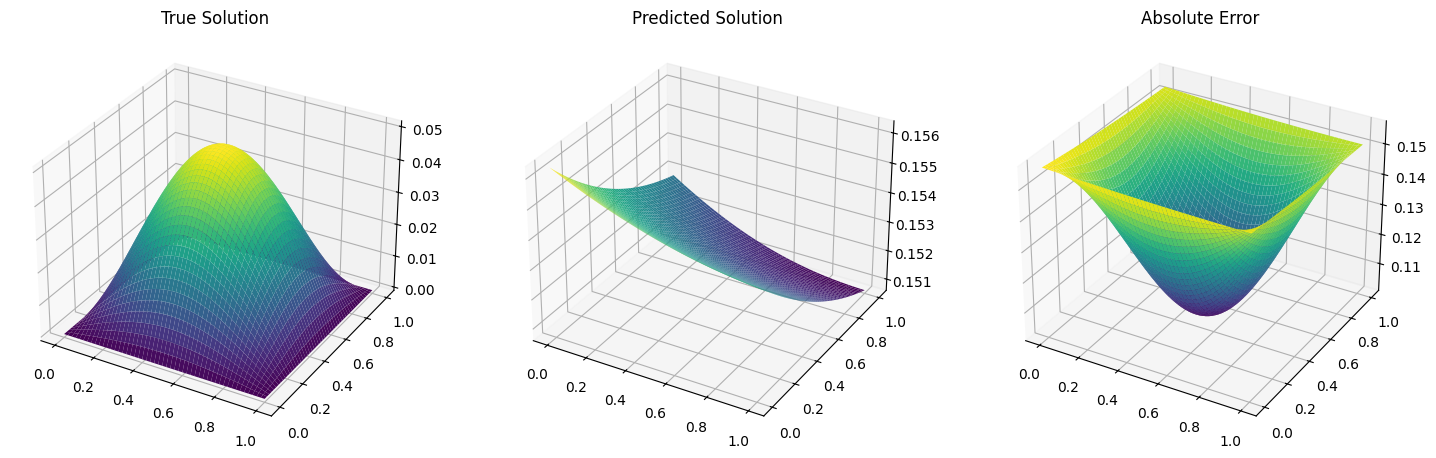

Adam Training:  40%|███▉      | 199/500 [00:18<00:25, 11.68epoch/s, Total Loss=0.561, Interior Loss=-0.778, Boundary Loss=1.91, pinns loss=0.00602, bndr_loss=0.00953, precision_interior=1, precision_boundary=0.999]

Validation L2 Error at epoch 200: 0.08373461663722992


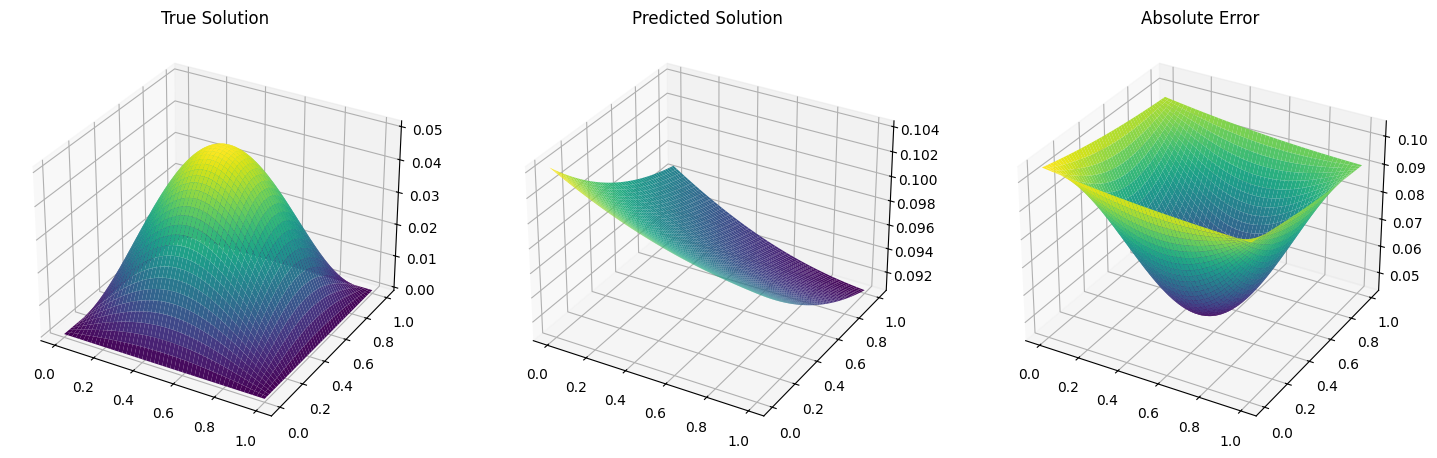

Adam Training:  60%|█████▉    | 298/500 [00:28<00:15, 13.07epoch/s, Total Loss=0.0585, Interior Loss=-0.374, Boundary Loss=0.494, pinns loss=0.00104, bndr_loss=0.00247, precision_interior=1, precision_boundary=0.999]

Validation L2 Error at epoch 300: 0.03750957176089287


In [ ]:
losses, interior_losses, boundary_losses = train(
    model,
    adam,
    lbfgs,
    log_var_interior,
    log_var_boundary,
    epochs = 1000,
    switch_epoch= 500,
    n_interior = 8000,
    n_boundary = 4000,
    print_interval = 50,
    save_path = 'biharmonic_DRM/biharmonic_model'
    )

In [13]:
# Plotting the losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Total Loss')
plt.plot(interior_losses, label='Interior Loss')
plt.plot(boundary_losses, label='Boundary Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid()
plt.savefig('biharmonic_DRM/training_losses.png')



Adam Training:   0%|          | 0/500 [00:00<?, ?epoch/s]c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Adam Training:  20%|██        | 101/500 [00:07<00:27, 14.32epoch/s, Total Loss=

Adam Training:   0%|          | 0/500 [00:00<?, ?epoch/s]c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Adam Training:  20%|██        | 101/500 [00:07<00:27, 14.32epoch/s, Total Loss=

Validation L2 Error at epoch 100: 0.1668606698513031


Adam Training:   0%|          | 0/500 [00:00<?, ?epoch/s]c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Adam Training:  20%|██        | 101/500 [00:07<00:27, 14.32epoch/s, Total Loss=

Validation L2 Error at epoch 100: 0.1668606698513031


Adam Training:  41%|████      | 203/500 [00:15<00:23, 12.51epoch/s, Total Loss=1.22, Interior Loss=-1.04, Boundary Loss=3.48, pinns Loss=0.0126, bndr Loss=0.0174, precision_interior=1, precision_boundary=0.998]

Adam Training:   0%|          | 0/500 [00:00<?, ?epoch/s]c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Adam Training:  20%|██        | 101/500 [00:07<00:27, 14.32epoch/s, Total Loss=

Validation L2 Error at epoch 100: 0.1668606698513031


Adam Training:  41%|████      | 203/500 [00:15<00:23, 12.51epoch/s, Total Loss=1.22, Interior Loss=-1.04, Boundary Loss=3.48, pinns Loss=0.0126, bndr Loss=0.0174, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 200: 0.1182311549782753


Adam Training:   0%|          | 0/500 [00:00<?, ?epoch/s]c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Adam Training:  20%|██        | 101/500 [00:07<00:27, 14.32epoch/s, Total Loss=

Validation L2 Error at epoch 100: 0.1668606698513031


Adam Training:  41%|████      | 203/500 [00:15<00:23, 12.51epoch/s, Total Loss=1.22, Interior Loss=-1.04, Boundary Loss=3.48, pinns Loss=0.0126, bndr Loss=0.0174, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 200: 0.1182311549782753


Adam Training:  60%|██████    | 301/500 [00:23<00:16, 12.18epoch/s, Total Loss=0.303, Interior Loss=-0.635, Boundary Loss=1.25, pinns Loss=0.00354, bndr Loss=0.00623, precision_interior=1, precision_boundary=0.998]

Adam Training:   0%|          | 0/500 [00:00<?, ?epoch/s]c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Adam Training:  20%|██        | 101/500 [00:07<00:27, 14.32epoch/s, Total Loss=

Validation L2 Error at epoch 100: 0.1668606698513031


Adam Training:  41%|████      | 203/500 [00:15<00:23, 12.51epoch/s, Total Loss=1.22, Interior Loss=-1.04, Boundary Loss=3.48, pinns Loss=0.0126, bndr Loss=0.0174, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 200: 0.1182311549782753


Adam Training:  60%|██████    | 301/500 [00:23<00:16, 12.18epoch/s, Total Loss=0.303, Interior Loss=-0.635, Boundary Loss=1.25, pinns Loss=0.00354, bndr Loss=0.00623, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 300: 0.06529223173856735


Adam Training:   0%|          | 0/500 [00:00<?, ?epoch/s]c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Adam Training:  20%|██        | 101/500 [00:07<00:27, 14.32epoch/s, Total Loss=

Validation L2 Error at epoch 100: 0.1668606698513031


Adam Training:  41%|████      | 203/500 [00:15<00:23, 12.51epoch/s, Total Loss=1.22, Interior Loss=-1.04, Boundary Loss=3.48, pinns Loss=0.0126, bndr Loss=0.0174, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 200: 0.1182311549782753


Adam Training:  60%|██████    | 301/500 [00:23<00:16, 12.18epoch/s, Total Loss=0.303, Interior Loss=-0.635, Boundary Loss=1.25, pinns Loss=0.00354, bndr Loss=0.00623, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 300: 0.06529223173856735


Adam Training:  80%|████████  | 401/500 [00:33<00:08, 11.21epoch/s, Total Loss=-0.00044, Interior Loss=-0.303, Boundary Loss=0.305, pinns Loss=0.00055, bndr Loss=0.00152, precision_interior=1, precision_boundary=0.998]

Adam Training:   0%|          | 0/500 [00:00<?, ?epoch/s]c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Adam Training:  20%|██        | 101/500 [00:07<00:27, 14.32epoch/s, Total Loss=

Validation L2 Error at epoch 100: 0.1668606698513031


Adam Training:  41%|████      | 203/500 [00:15<00:23, 12.51epoch/s, Total Loss=1.22, Interior Loss=-1.04, Boundary Loss=3.48, pinns Loss=0.0126, bndr Loss=0.0174, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 200: 0.1182311549782753


Adam Training:  60%|██████    | 301/500 [00:23<00:16, 12.18epoch/s, Total Loss=0.303, Interior Loss=-0.635, Boundary Loss=1.25, pinns Loss=0.00354, bndr Loss=0.00623, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 300: 0.06529223173856735


Adam Training:  80%|████████  | 401/500 [00:33<00:08, 11.21epoch/s, Total Loss=-0.00044, Interior Loss=-0.303, Boundary Loss=0.305, pinns Loss=0.00055, bndr Loss=0.00152, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 400: 0.02858593687415123


Adam Training:   0%|          | 0/500 [00:00<?, ?epoch/s]c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Adam Training:  20%|██        | 101/500 [00:07<00:27, 14.32epoch/s, Total Loss=

Validation L2 Error at epoch 100: 0.1668606698513031


Adam Training:  41%|████      | 203/500 [00:15<00:23, 12.51epoch/s, Total Loss=1.22, Interior Loss=-1.04, Boundary Loss=3.48, pinns Loss=0.0126, bndr Loss=0.0174, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 200: 0.1182311549782753


Adam Training:  60%|██████    | 301/500 [00:23<00:16, 12.18epoch/s, Total Loss=0.303, Interior Loss=-0.635, Boundary Loss=1.25, pinns Loss=0.00354, bndr Loss=0.00623, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 300: 0.06529223173856735


Adam Training:  80%|████████  | 401/500 [00:33<00:08, 11.21epoch/s, Total Loss=-0.00044, Interior Loss=-0.303, Boundary Loss=0.305, pinns Loss=0.00055, bndr Loss=0.00152, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 400: 0.02858593687415123


Adam Training: 100%|██████████| 500/500 [00:42<00:00, 11.79epoch/s, Total Loss=-0.0345, Interior Loss=-0.178, Boundary Loss=0.112, pinns Loss=0.000243, bndr Loss=0.000562, precision_interior=1, precision_boundary=0.998]



Adam Training:   0%|          | 0/500 [00:00<?, ?epoch/s]c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Adam Training:  20%|██        | 101/500 [00:07<00:27, 14.32epoch/s, Total Loss=

Validation L2 Error at epoch 100: 0.1668606698513031


Adam Training:  41%|████      | 203/500 [00:15<00:23, 12.51epoch/s, Total Loss=1.22, Interior Loss=-1.04, Boundary Loss=3.48, pinns Loss=0.0126, bndr Loss=0.0174, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 200: 0.1182311549782753


Adam Training:  60%|██████    | 301/500 [00:23<00:16, 12.18epoch/s, Total Loss=0.303, Interior Loss=-0.635, Boundary Loss=1.25, pinns Loss=0.00354, bndr Loss=0.00623, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 300: 0.06529223173856735


Adam Training:  80%|████████  | 401/500 [00:33<00:08, 11.21epoch/s, Total Loss=-0.00044, Interior Loss=-0.303, Boundary Loss=0.305, pinns Loss=0.00055, bndr Loss=0.00152, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 400: 0.02858593687415123


Adam Training: 100%|██████████| 500/500 [00:42<00:00, 11.79epoch/s, Total Loss=-0.0345, Interior Loss=-0.178, Boundary Loss=0.112, pinns Loss=0.000243, bndr Loss=0.000562, precision_interior=1, precision_boundary=0.998]



Validation L2 Error at epoch 500: 0.018510593101382256
Switching to L-BFGS Optimizer


Adam Training:   0%|          | 0/500 [00:00<?, ?epoch/s]c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Adam Training:  20%|██        | 101/500 [00:07<00:27, 14.32epoch/s, Total Loss=

Validation L2 Error at epoch 100: 0.1668606698513031


Adam Training:  41%|████      | 203/500 [00:15<00:23, 12.51epoch/s, Total Loss=1.22, Interior Loss=-1.04, Boundary Loss=3.48, pinns Loss=0.0126, bndr Loss=0.0174, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 200: 0.1182311549782753


Adam Training:  60%|██████    | 301/500 [00:23<00:16, 12.18epoch/s, Total Loss=0.303, Interior Loss=-0.635, Boundary Loss=1.25, pinns Loss=0.00354, bndr Loss=0.00623, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 300: 0.06529223173856735


Adam Training:  80%|████████  | 401/500 [00:33<00:08, 11.21epoch/s, Total Loss=-0.00044, Interior Loss=-0.303, Boundary Loss=0.305, pinns Loss=0.00055, bndr Loss=0.00152, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 400: 0.02858593687415123


Adam Training: 100%|██████████| 500/500 [00:42<00:00, 11.79epoch/s, Total Loss=-0.0345, Interior Loss=-0.178, Boundary Loss=0.112, pinns Loss=0.000243, bndr Loss=0.000562, precision_interior=1, precision_boundary=0.998]



Validation L2 Error at epoch 500: 0.018510593101382256
Switching to L-BFGS Optimizer


L-BFGS Training:   0%|          | 0/501 [00:44<?, ?epoch/s, Total Loss=-0.0661, Interior Loss=-0.213, Boundary Loss=0.0846, pinns Loss=0.000169, bndr Loss=0.000423]

Adam Training:   0%|          | 0/500 [00:00<?, ?epoch/s]c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Adam Training:  20%|██        | 101/500 [00:07<00:27, 14.32epoch/s, Total Loss=

Validation L2 Error at epoch 100: 0.1668606698513031


Adam Training:  41%|████      | 203/500 [00:15<00:23, 12.51epoch/s, Total Loss=1.22, Interior Loss=-1.04, Boundary Loss=3.48, pinns Loss=0.0126, bndr Loss=0.0174, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 200: 0.1182311549782753


Adam Training:  60%|██████    | 301/500 [00:23<00:16, 12.18epoch/s, Total Loss=0.303, Interior Loss=-0.635, Boundary Loss=1.25, pinns Loss=0.00354, bndr Loss=0.00623, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 300: 0.06529223173856735


Adam Training:  80%|████████  | 401/500 [00:33<00:08, 11.21epoch/s, Total Loss=-0.00044, Interior Loss=-0.303, Boundary Loss=0.305, pinns Loss=0.00055, bndr Loss=0.00152, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 400: 0.02858593687415123


Adam Training: 100%|██████████| 500/500 [00:42<00:00, 11.79epoch/s, Total Loss=-0.0345, Interior Loss=-0.178, Boundary Loss=0.112, pinns Loss=0.000243, bndr Loss=0.000562, precision_interior=1, precision_boundary=0.998]



Validation L2 Error at epoch 500: 0.018510593101382256
Switching to L-BFGS Optimizer


L-BFGS Training:   0%|          | 0/501 [00:44<?, ?epoch/s, Total Loss=-0.0661, Interior Loss=-0.213, Boundary Loss=0.0846, pinns Loss=0.000169, bndr Loss=0.000423]

Validation L2 Error at epoch 500: 0.01555402297526598


Adam Training:   0%|          | 0/500 [00:00<?, ?epoch/s]c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Adam Training:  20%|██        | 101/500 [00:07<00:27, 14.32epoch/s, Total Loss=

Validation L2 Error at epoch 100: 0.1668606698513031


Adam Training:  41%|████      | 203/500 [00:15<00:23, 12.51epoch/s, Total Loss=1.22, Interior Loss=-1.04, Boundary Loss=3.48, pinns Loss=0.0126, bndr Loss=0.0174, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 200: 0.1182311549782753


Adam Training:  60%|██████    | 301/500 [00:23<00:16, 12.18epoch/s, Total Loss=0.303, Interior Loss=-0.635, Boundary Loss=1.25, pinns Loss=0.00354, bndr Loss=0.00623, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 300: 0.06529223173856735


Adam Training:  80%|████████  | 401/500 [00:33<00:08, 11.21epoch/s, Total Loss=-0.00044, Interior Loss=-0.303, Boundary Loss=0.305, pinns Loss=0.00055, bndr Loss=0.00152, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 400: 0.02858593687415123


Adam Training: 100%|██████████| 500/500 [00:42<00:00, 11.79epoch/s, Total Loss=-0.0345, Interior Loss=-0.178, Boundary Loss=0.112, pinns Loss=0.000243, bndr Loss=0.000562, precision_interior=1, precision_boundary=0.998]



Validation L2 Error at epoch 500: 0.018510593101382256
Switching to L-BFGS Optimizer


L-BFGS Training:   0%|          | 0/501 [00:44<?, ?epoch/s, Total Loss=-0.0661, Interior Loss=-0.213, Boundary Loss=0.0846, pinns Loss=0.000169, bndr Loss=0.000423]

Validation L2 Error at epoch 500: 0.01555402297526598


L-BFGS Training:   7%|▋         | 35/501 [01:59<26:35,  3.42s/epoch, Total Loss=-0.0661, Interior Loss=-0.213, Boundary Loss=0.0846, pinns Loss=0.000169, bndr Loss=0.000423]]



Adam Training:   0%|          | 0/500 [00:00<?, ?epoch/s]c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Adam Training:  20%|██        | 101/500 [00:07<00:27, 14.32epoch/s, Total Loss=

Validation L2 Error at epoch 100: 0.1668606698513031


Adam Training:  41%|████      | 203/500 [00:15<00:23, 12.51epoch/s, Total Loss=1.22, Interior Loss=-1.04, Boundary Loss=3.48, pinns Loss=0.0126, bndr Loss=0.0174, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 200: 0.1182311549782753


Adam Training:  60%|██████    | 301/500 [00:23<00:16, 12.18epoch/s, Total Loss=0.303, Interior Loss=-0.635, Boundary Loss=1.25, pinns Loss=0.00354, bndr Loss=0.00623, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 300: 0.06529223173856735


Adam Training:  80%|████████  | 401/500 [00:33<00:08, 11.21epoch/s, Total Loss=-0.00044, Interior Loss=-0.303, Boundary Loss=0.305, pinns Loss=0.00055, bndr Loss=0.00152, precision_interior=1, precision_boundary=0.998]

Validation L2 Error at epoch 400: 0.02858593687415123


Adam Training: 100%|██████████| 500/500 [00:42<00:00, 11.79epoch/s, Total Loss=-0.0345, Interior Loss=-0.178, Boundary Loss=0.112, pinns Loss=0.000243, bndr Loss=0.000562, precision_interior=1, precision_boundary=0.998]



Validation L2 Error at epoch 500: 0.018510593101382256
Switching to L-BFGS Optimizer


L-BFGS Training:   0%|          | 0/501 [00:44<?, ?epoch/s, Total Loss=-0.0661, Interior Loss=-0.213, Boundary Loss=0.0846, pinns Loss=0.000169, bndr Loss=0.000423]

Validation L2 Error at epoch 500: 0.01555402297526598


L-BFGS Training:   7%|▋         | 35/501 [01:59<26:35,  3.42s/epoch, Total Loss=-0.0661, Interior Loss=-0.213, Boundary Loss=0.0846, pinns Loss=0.000169, bndr Loss=0.000423]]



KeyboardInterrupt: 